Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [2]:
from itertools import combinations
from collections import namedtuple, defaultdict
from random import choice, random
from copy import deepcopy
import json

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
State = namedtuple('State', ['x', 'o'])

In [4]:
MAGIC = [2, 7, 6, 9, 5, 1, 4, 3, 8]

In [4]:
class Color:
    RESET = '\033[0m'
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    PURPLE = '\033[95m'
    CYAN = '\033[96m'

In [5]:
def print_board(pos):
    """Nicely prints the board"""
    for r in range(3):
        for c in range(3):
            i = r * 3 + c
            if MAGIC[i] in pos.x:
                print('X', end='')
            elif MAGIC[i] in pos.o:
                print('O', end='')
            else:
                print('.', end='')
        print()
    print()

In [6]:
def win(elements):
    """Checks is elements is winning"""
    return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
    """Evaluate state: +1 first player wins"""
    if win(pos.x):
        return 1
    elif win(pos.o):
        return -1
    else:
        return 0
    
    

In [7]:
def random_game():
    trajectory = list()
    state = State(set(), set())
    available = set(range(1, 9+1))
    while available:
        x = choice(list(available))
        state.x.add(x)
        trajectory.append(deepcopy(state))
        available.remove(x)
        if win(state.x) or not available:
            break

        o = choice(list(available))
        state.o.add(o)
        trajectory.append(deepcopy(state))
        available.remove(o)
        if win(state.o):
            break
    return trajectory

```python
value_dictionary = defaultdict(float)
hit_state = defaultdict(int)
epsilon = 0.001

for steps in tqdm(range(500_000)):
    trajectory = random_game()
    final_reward = state_value(trajectory[-1])
    for state in trajectory:
        hashable_state = (frozenset(state.x), frozenset(state.o))
        hit_state[hashable_state] += 1
        value_dictionary[hashable_state] = value_dictionary[
            hashable_state
        ] + epsilon * (final_reward - value_dictionary[hashable_state])
```

In [7]:
def rotate(matrice):
    return list(zip(*reversed(matrice)))

SYMM = defaultdict(list)

original_table = [MAGIC[i:i + 3] for i in range(0, len(MAGIC), 3)]
for i in range(3):
    original_table = rotate(original_table)
    rotated_vec = [elem for r in original_table for elem in r]
    for idx, j in enumerate(MAGIC):
        SYMM[j].append(rotated_vec[idx])

for s in SYMM:
    print(f"s : {s} -> {SYMM[s]}")

x = {2, 7, 6}
s_x = {SYMM[e][0] for e in x}
s_x


s : 2 -> [4, 8, 6]
s : 7 -> [9, 3, 1]
s : 6 -> [2, 4, 8]
s : 9 -> [3, 1, 7]
s : 5 -> [5, 5, 5]
s : 1 -> [7, 9, 3]
s : 4 -> [8, 6, 2]
s : 3 -> [1, 7, 9]
s : 8 -> [6, 2, 4]


{2, 4, 9}

In [17]:
alpha = 0.1
gamma = 0.98
fixed_epsilon = 0.2
# fixed_epsilon = 0.            # if use optimistic initial values technique
# epsilon = fixed_epsilon

episodes = 200_000              # GLIE approach calculation
k = episodes
eps_k = 0.1
b = (eps_k * k) // (1 - eps_k)


class agent:
  def __init__(self):
    
    # zero initialization
    self.q_table = defaultdict(lambda: np.zeros(9, dtype=float))
    
    
    # optimistic initial value
    # self.q_table = defaultdict(lambda: np.full(9, 50, dtype=float))
  
  def get_action(self, state, available_actions, epsilon=fixed_epsilon):
    '''print("Get : ")
    print(f"Epsilon : {epsilon}")'''
    if np.random.rand() < epsilon:
      action =  choice(available_actions)
      '''print(f"{Color.YELLOW}rand action: {action+1}{Color.RESET}")'''
      return action
    else:
      hashable_state = (frozenset(state.x), frozenset(state.o))
      '''print(f"cumulative exp rew :\t{self.q_table[hashable_state][available_actions]}")'''
      best_action_index = np.argmax(self.q_table[hashable_state][available_actions])
      best_action_value = self.q_table[hashable_state][available_actions][best_action_index]
      best_action = list(available_actions)[best_action_index]
      '''print(f"{Color.GREEN}best action val:{best_action_value},\tbest action: {best_action+1}{Color.RESET}")'''
      return best_action
  
  def update(self, state, action, reward, next_state, done):
    '''print("Update : ")'''
    if done:
      target_value = reward
    else:
      hashable_next_state = (frozenset(next_state.x), frozenset(next_state.o))
      target_value = reward + np.max(gamma * self.q_table[hashable_next_state])
    
    '''print(f"t: {target_value}")'''
    
    hashable_state = (frozenset(state.x), frozenset(state.o))
    self.q_table[hashable_state][action] += (alpha * (target_value - self.q_table[hashable_state][action]))
    '''print(f"values : {self.q_table[hashable_state]}, value: {self.q_table[hashable_state][action]}")'''
    return

  def update_symm(self, state, action, reward, next_state, done):
    # regular update
    if done:
        target_value = reward
    else:
      # print(f"{next_state.x}, {next_state.o}")
      hashable_next_state = (frozenset(next_state.x), frozenset(next_state.o))
      target_value = reward + np.max(gamma * self.q_table[hashable_next_state])
    
    '''print(f"t: {target_value}")'''
    hashable_state = (frozenset(state.x), frozenset(state.o))
    self.q_table[hashable_state][action] += (alpha * (target_value - self.q_table[hashable_state][action]))
    '''print(f"values : {self.q_table[hashable_state]}, value: {self.q_table[hashable_state][action]}")'''
    # exploiting symm
    if state.x | state.o != {5}:
      for i in range(3):
        if done:
            target_value = reward
        else:
          # print(f"{[SYMM[e][i] for e in next_state.x]}, {[SYMM[e][i] for e in next_state.o]}")
          # attenzione, se ho solo mossa 5, faccio lo stesso conto 5 volte
          hashable_next_state = (frozenset({SYMM[e][i] for e in next_state.x}), frozenset({SYMM[e][i] for e in next_state.o}))
          target_value = reward + np.max(gamma * self.q_table[hashable_next_state])
        
        '''print(f"t: {target_value}")'''
        hashable_state = (frozenset({SYMM[e][i] for e in state.x}), frozenset({SYMM[e][i] for e in state.o}))
        self.q_table[hashable_state][action] += (alpha * (target_value - self.q_table[hashable_state][action]))
        '''print(f"values : {self.q_table[hashable_state]}, value: {self.q_table[hashable_state][action]}")'''
    return
    
  def play(self, state, available_actions):
    hashable_state = (frozenset(state.x), frozenset(state.o))
    best_action_index = np.argmax(self.q_table[hashable_state][available_actions])
    best_action_value = self.q_table[hashable_state][available_actions][best_action_index]
    best_action = list(available_actions)[best_action_index]
    available_actions.remove(best_action)
    return best_action, available_actions
  
  def save_q_table(self, filename):
    q_table_dict = {str(key): value.tolist() for key, value in self.q_table.items()}
    with open(filename, 'w') as file:
      json.dump(q_table_dict, file)

  def load_q_table(self, filename):
    with open(filename, 'r') as file:
      q_table_dict = json.load(file)

    self.q_table = defaultdict(lambda: np.zeros(9, dtype=float))
    for key, value in q_table_dict.items():
      for i in range(9):
        self.q_table[eval(key)] = np.array(value)

  

In [9]:
def perform_action(action, available_actions, state, turn):
    done = False
    if turn == 0:
      state.o.add(action+1)
    else:
      state.x.add(action+1)
    available_actions.remove(action)
    if len(available_actions) == 0: done = True
    return state, done

def get_reward_0(state, done):
  if win(state.o):
    '''print("win: o")'''
    return -10, True
  elif win(state.x):
    '''print("win: x")'''
    return 5, True
  else:
    return 0, done

target_set = {2, 4, 6, 8}

def get_reward_1(state, done, available_actions, turn=1):
    if win(state.o):
      return -100, True
    
    reward = 0
    count_combinations = 0

    if turn == 1: # if turn of x
      # if o can win with one action from the remaining and x is not blocking it => reward -= 3
      # o can perform it the next turn !
      elements = list(state.o)
      for act in available_actions:
        elements.append(act+1)
        if any(sum(c) == 15 for c in combinations(elements, 3)):
          reward -= 3
        elements.remove(act+1)

    # if the action of x is blocking the winning of o => reward += 1
    for x in state.x:
      elements = list(state.o)
      elements.append(x)
      count_combinations += sum(1 for c in combinations(elements, 3) if sum(c) == 15)
      elements.remove(x)
    reward += count_combinations
    # if x sets 3 elements at the corner (config that facilitates the win)
    cmn = state.x & target_set              # reward += sum(1 for c in combinations(state.x, 3) if c in target_vector)
    if len(cmn) >= 3: 
      reward += len(cmn) - 2
        
    if win(state.x):
      '''print("win: x")'''
      reward += 50
      return reward, True
    else:
      return reward, done
    
def get_reward_2(state, done, available_actions, turn=1):
  if win(state.o):
    return -100, True
  
  if win(state.x):
    return 50, True

  if turn == 1: # if turn of x
    # if o can win with one action from the remaining and x is not blocking it => reward = 100
    # o can perform it the next turn !
    elements = list(state.o)
    for act in available_actions:
      elements.append(act+1)
      if any(sum(c) == 15 for c in combinations(elements, 3)):
        return -100, done
      elements.remove(act+1)

  reward = 0

  # reward += 10 for each action of x that blocks the winning of o
  elements = list(state.o)
  for x in state.x:
    elements.append(x)
    reward += 10 * sum(1 for c in combinations(elements, 3) if sum(c) == 15)
    elements.remove(x)
  
  # if x sets 3 elements at the corner (config that facilitates the win)
    cmn = state.x & target_set              # reward += sum(1 for c in combinations(state.x, 3) if c in target_vector)
    if len(cmn) >= 3: 
      reward += 5*(len(cmn) - 2)
    
  return reward, done

def my_player(state, available_actions, flag):
   # random player
  action = choice(available_actions)

  # win if you can
  if len(state.o) >= 2 and not any(sum(c) == 15 for c in combinations(state.o, 3)):
    elements = list(state.o)
    for act in available_actions:
      elements.append(act+1)
      if any(sum(c) == 15 for c in combinations(elements, 3)):
        action = act
        flag = 1
        return action, flag
      elements.remove(act+1)
  
  # if you can block the winning do it
  for act in available_actions:
    elements = list(state.x)
    elements.append(act+1)
    if win(elements):  # if the action make x win => prevent it
      action = act
      return action, flag
    elements.remove(act+1)
      
  return action, flag
    

In [10]:
def plot_data(data, name):
    plt.plot(data)
    plt.xlabel('episodes/delta_iterations')
    plt.ylabel('win rate')
    plt.title('win evolution over episodes/delta_iterations')
    print(f'{name}.png')
    plt.show()

In [ ]:
'''
a = agent()
state = State(set(), set())
done = False
available_actions = list(range(9))
turn = 1
act = list()
while not done:
  action = a.get_action(state, available_actions)
  print(f"actual s: {state}")
  next_state, done = perform_action(action, available_actions, deepcopy(state), turn)
  act.append(action+1)
  print(f"turn: {'o' if turn == 0 else 'x'}")
  print(f"action: {action+1}")
  print_board(state)
  print_board(next_state)
  turn = 1- turn
  print(f"next s: {next_state}")
  reward, done = get_reward(next_state, done, available_actions)
  if done: print("done")
  a.update(state, action, reward, next_state, done)
  state = next_state

print_board(state)
print(act)
'''

'\na = agent()\nstate = State(set(), set())\ndone = False\navailable_actions = list(range(9))\nturn = 1\nact = list()\nwhile not done:\n  action = a.get_action(state, available_actions)\n  print(f"actual s: {state}")\n  next_state, done = perform_action(action, available_actions, deepcopy(state), turn)\n  act.append(action+1)\n  print(f"turn: {\'o\' if turn == 0 else \'x\'}")\n  print(f"action: {action+1}")\n  print_board(state)\n  print_board(next_state)\n  turn = 1- turn\n  print(f"next s: {next_state}")\n  reward, done = get_reward(next_state, done, available_actions)\n  if done: print("done")\n  a.update(state, action, reward, next_state, done)\n  state = next_state\n\nprint_board(state)\nprint(act)\n'

'\na = agent()\nstate = State(set(), set())\ndone = False\navailable_actions = list(range(9))\nturn = 1\nact = list()\nwhile not done:\n  action = a.get_action(state, available_actions)\n  print(f"actual s: {state}")\n  next_state, done = perform_action(action, available_actions, deepcopy(state), turn)\n  act.append(action+1)\n  print(f"turn: {\'o\' if turn == 0 else \'x\'}")\n  print(f"action: {action+1}")\n  print_board(state)\n  print_board(next_state)\n  turn = 1- turn\n  print(f"next s: {next_state}")\n  reward, done = get_reward(next_state, done, available_actions)\n  if done: print("done")\n  a.update(state, action, reward, next_state, done)\n  state = next_state\n\nprint_board(state)\nprint(act)\n'

## Training

Only one training;
Use of :
* fixed epsilon approach
* first turn is random
* `episodes`
* `my_player()`
* `get_reward_0()`

  0%|          | 0/200000 [00:00<?, ?it/s]

200000_(0)_r0.png


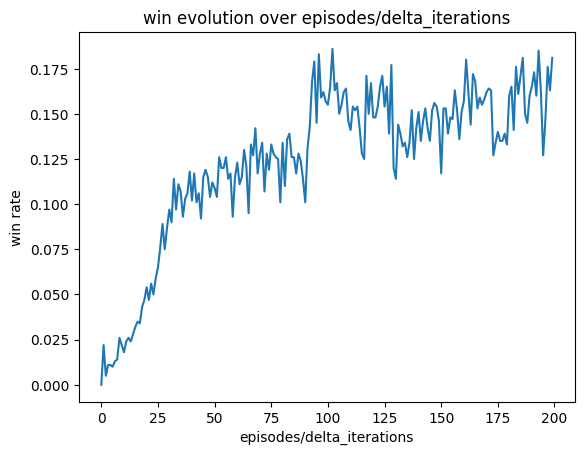

In [11]:
# epsilon = fixed_epsilon
save_num = 0
a = agent()
d_iter = 1000
data = np.zeros((episodes//d_iter))
hist  = np.zeros(episodes)
for i in tqdm(range(episodes)):
  state = State(set(), set())
  done = False
  available_actions = list(range(9))
  #turn = 1
  turn = np.random.choice([0,1])
  '''print(f"starts: {'o' if turn == 0 else 'x'}")'''
  state = State(set(), set())
  done = False
  available_actions = list(range(9))
  while not done:
    flag = 0
    if turn == 1:                                                                   # if turn of x
      # epsilon greedy player
      action = a.get_action(state, available_actions)
      # fixed eps
      # action = a.get_action(state, available_actions)
    
    else:                                                                           # if turn of o
      action, flag = my_player(state, available_actions, flag)
    
    # print(f"actual s: {state}")
    next_state, done = perform_action(action, available_actions, deepcopy(state), turn)
    '''if flag==1:
      print_board(next_state)'''    
    # print(f"turn: {'o' if turn == 0 else 'x'}") # print(f"action: {action+1}")  # print(f"s:{state}, ns:{next_state}")  # print_board(state)  # print_board(next_state) # print(f"next s: {next_state}")

    reward, done = get_reward_0(next_state, done)
    '''if flag == 1 and done: print("won for choice of my_player")'''
    a.update(state, action, reward, next_state, done)
    state = next_state
    if reward == 5: hist[i] = 1
    turn = 1- turn
    #if done:  print_board(state)
  if i % d_iter == 0:
      data[i//d_iter] = sum(hist[i-d_iter:i])/d_iter

plot_data(data, f'{episodes}_({save_num})_r0_fixed_eps')
a.save_q_table(f"q_table_{episodes}_({save_num})_r0_fixed_eps.json")

Only one training;
Use of :
* GLIE approach
* first turn is random
* `episodes`
* `my_player()`
* `get_reward_0()`

  0%|          | 0/200000 [00:00<?, ?it/s]

200000_(0)_r0.png


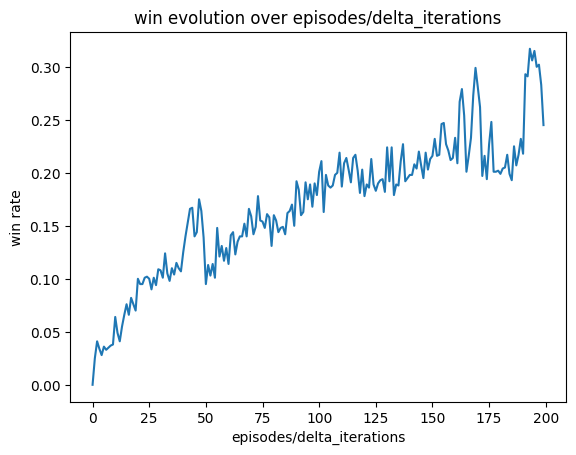

In [12]:
# epsilon = fixed_epsilon
save_num = 0
a = agent()
d_iter = 1000
data = np.zeros((episodes//d_iter))
hist  = np.zeros(episodes)
for i in tqdm(range(episodes)):
  state = State(set(), set())
  done = False
  available_actions = list(range(9))
  #turn = 1
  turn = np.random.choice([0,1])
  '''print(f"starts: {'o' if turn == 0 else 'x'}")'''
  state = State(set(), set())
  done = False
  available_actions = list(range(9))
  epsilon = b / (b + i)
  while not done:
    flag = 0
    if turn == 1:                                                                   # if turn of x
      # epsilon greedy player
      action = a.get_action(state, available_actions, epsilon)
      # fixed eps
      # action = a.get_action(state, available_actions)
    
    else:                                                                           # if turn of o
      action, flag = my_player(state, available_actions, flag)
    
    # print(f"actual s: {state}")
    next_state, done = perform_action(action, available_actions, deepcopy(state), turn)
    '''if flag==1:
      print_board(next_state)'''    
    # print(f"turn: {'o' if turn == 0 else 'x'}") # print(f"action: {action+1}")  # print(f"s:{state}, ns:{next_state}")  # print_board(state)  # print_board(next_state) # print(f"next s: {next_state}")

    reward, done = get_reward_0(next_state, done)
    '''if flag == 1 and done: print("won for choice of my_player")'''
    a.update(state, action, reward, next_state, done)
    state = next_state
    if reward == 5: hist[i] = 1
    turn = 1- turn
    #if done:  print_board(state)
  if i % d_iter == 0:
      data[i//d_iter] = sum(hist[i-d_iter:i])/d_iter

plot_data(data, f'{episodes}_({save_num})_r0')
a.save_q_table(f"q_table_{episodes}_({save_num})_r0.json")

Three trainings;
Use of :
* GLIE approach
* first turn is random
* `episodes`
* `my_player()`
* `get_reward_1()`

  0%|          | 0/200000 [00:00<?, ?it/s]

200000_(0)_r1.png


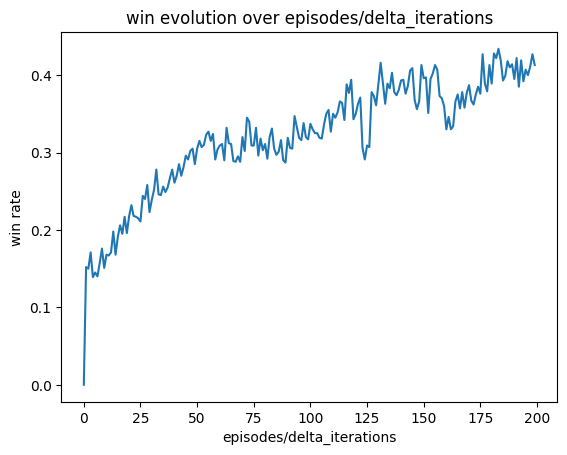

  0%|          | 0/200000 [00:00<?, ?it/s]

200000_(1)_r1.png


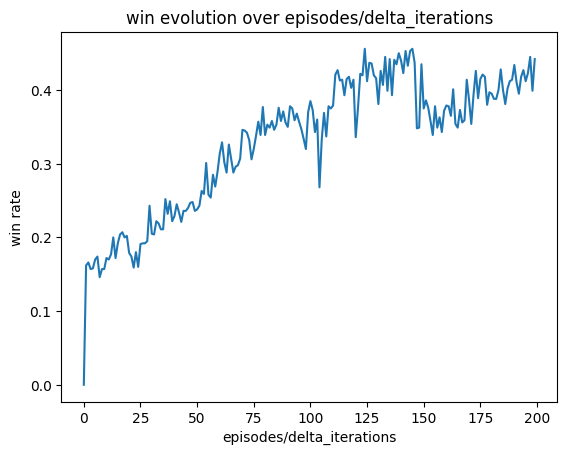

  0%|          | 0/200000 [00:00<?, ?it/s]

200000_(2)_r1.png


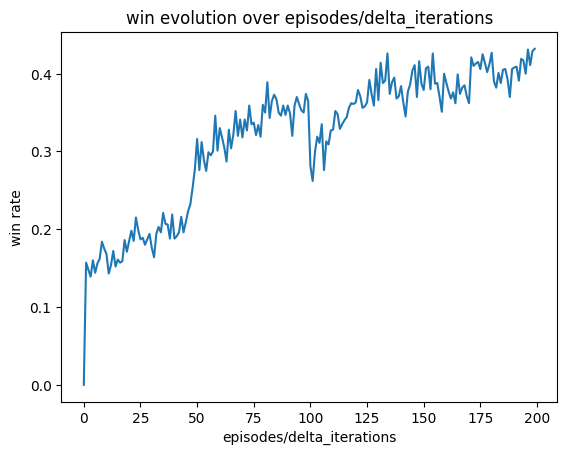

In [ ]:
# epsilon = fixed_epsilon
list_hist = list()
d_iter = 1000

for save_num in range(3):
  a = agent()
  data = np.zeros((episodes//d_iter))
  hist  = np.zeros(episodes)
  for i in tqdm(range(episodes)):
    state = State(set(), set())
    done = False
    available_actions = list(range(9))
    #turn = 1
    turn = np.random.choice([0,1])
    '''print(f"starts: {'o' if turn == 0 else 'x'}")'''
    state = State(set(), set())
    epsilon = b / (b + i)
    while not done:
      flag = 0
      if turn == 1:
        # epsilon greedy player
        action = a.get_action(state, available_actions, epsilon)
        # fixed eps
        # action = a.get_action(state, available_actions)
      
      else:
        action, flag = my_player(state, available_actions, flag)
      
      # print(f"actual s: {state}")
      next_state, done = perform_action(action, available_actions, deepcopy(state), turn)
      '''if flag==1:
        print_board(next_state)'''
      
      reward, done = get_reward_1(next_state, done, available_actions, turn)
      '''if flag == 1 and done: print("won for choice of my_player")'''
      a.update(state, action, reward, next_state, done)
      state = next_state
      if done and turn == 1: hist[i] = 1
      turn = 1 - turn
      #if done:  print_board(state)
    if i % d_iter == 0:
      data[i//d_iter] = sum(hist[i-d_iter:i])/d_iter
  plot_data(data, f'{episodes}_({save_num})_r1')
  list_hist.append(hist)
  a.save_q_table(f"q_table_{episodes}_({save_num})_r1.json")

Three trainings;
Use of :
* GLIE approach
* first turn is random
* `episodes`
* `my_player()`
* `get_reward_2()`

  0%|          | 0/200000 [00:00<?, ?it/s]

200000_(0)_r2.png


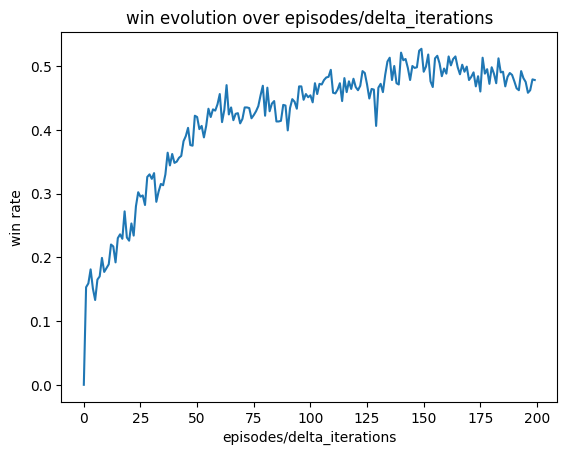

  0%|          | 0/200000 [00:00<?, ?it/s]

200000_(1)_r2.png


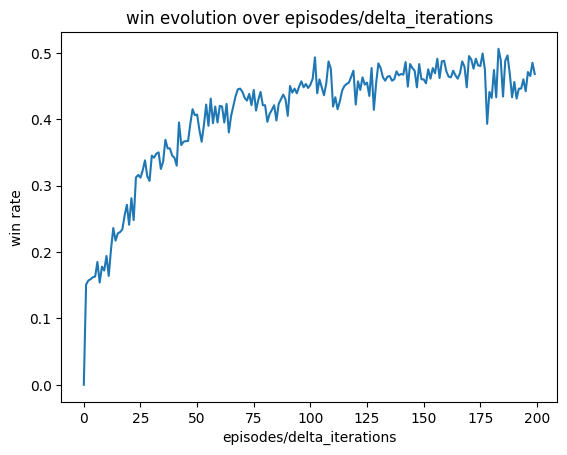

  0%|          | 0/200000 [00:00<?, ?it/s]

200000_(2)_r2.png


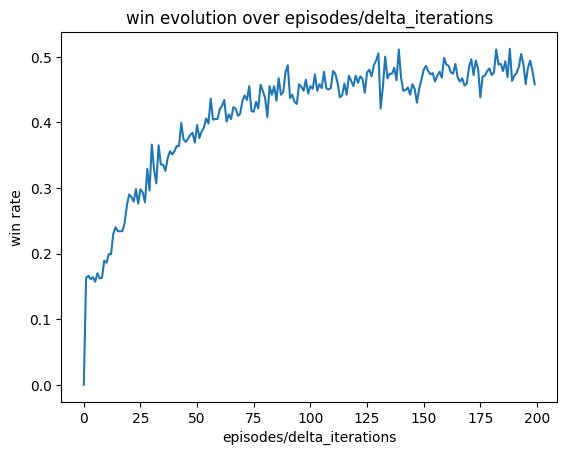

In [ ]:
# epsilon = fixed_epsilon
list_hist = list()
d_iter = 1000

for save_num in range(3):
  a = agent()
  data = np.zeros((episodes//d_iter))
  hist  = np.zeros(episodes)
  for i in tqdm(range(episodes)):
    state = State(set(), set())
    done = False
    available_actions = list(range(9))
    #turn = 1
    turn = np.random.choice([0,1])
    '''print(f"starts: {'o' if turn == 0 else 'x'}")'''
    state = State(set(), set())
    epsilon = b / (b + i)
    while not done:
      flag = 0
      if turn == 1:
        # epsilon greedy player
        action = a.get_action(state, available_actions, epsilon)
        # fixed eps
        # action = a.get_action(state, available_actions)
      
      else:
        action, flag = my_player(state, available_actions, flag)
      
      # print(f"actual s: {state}")
      next_state, done = perform_action(action, available_actions, deepcopy(state), turn)
      '''if flag==1:
        print_board(next_state)'''
      
      reward, done = get_reward_2(next_state, done, available_actions, turn)
      '''if flag == 1 and done: print("won for choice of my_player")'''
      a.update(state, action, reward, next_state, done)
      state = next_state
      if done and turn == 1: hist[i] = 1
      turn = 1 - turn
      #if done:  print_board(state)
    if i % d_iter == 0:
      data[i//d_iter] = sum(hist[i-d_iter:i])/d_iter
  plot_data(data, f'{episodes}_({save_num})_r2')
  list_hist.append(hist)
  a.save_q_table(f"q_table_{episodes}_({save_num})_r2.json")

## Exploiting symmetries

Use of :
* GLIE approach
* first turn is random
* `episodes`
*  `my_player` as opponent
* symmetries

  0%|          | 0/200000 [00:00<?, ?it/s]

200000_(0)_r2_symm.png


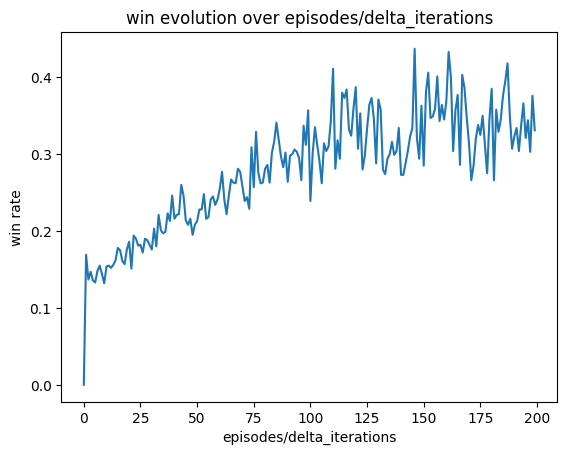

In [21]:
# epsilon = fixed_epsilon
d_iter = 1000

save_num = 0
a = agent()
data = np.zeros((episodes//d_iter))
hist  = np.zeros(episodes)
for i in tqdm(range(episodes)):
  state = State(set(), set())
  done = False
  available_actions = list(range(9))
  #turn = 1
  turn = np.random.choice([0,1])
  '''print(f"starts: {'o' if turn == 0 else 'x'}")'''
  state = State(set(), set())
  epsilon = b / (b + i)
  while not done:
    flag = 0
    if turn == 1:
      # epsilon greedy player
      action = a.get_action(state, available_actions, epsilon)
      # fixed eps
      # action = a.get_action(state, available_actions)
    
    else:
      action, flag = my_player(state, available_actions, flag)
    
    # print(f"actual s: {state}")
    next_state, done = perform_action(action, available_actions, deepcopy(state), turn)
    '''if flag==1:
      print_board(next_state)'''
    
    reward, done = get_reward_2(next_state, done, available_actions, turn)
    '''if flag == 1 and done: print("won for choice of my_player")'''
    a.update_symm(state, action, reward, next_state, done)
    state = next_state
    if done and turn == 1: hist[i] = 1
    turn = 1 - turn
    #if done:  print_board(state)
  if i % d_iter == 0:
    data[i//d_iter] = sum(hist[i-d_iter:i])/d_iter
plot_data(data, f'{episodes}_({save_num})_r2_symm')
a.save_q_table(f"q_table_{episodes}_({save_num})_r2_symm.json")

## Testing

In [25]:
def plot_stats(win, loss, draw, name):
  perc = [win, loss, draw]
  lab = ['Win', 'Loss', 'Draw']
  colors = ['green', 'red', 'yellow']
  plt.bar(lab, perc, color=colors)
  plt.xlabel('Result')
  plt.ylabel('Percentage')
  plt.title('Statistics')

  print(f'{name}.png')
  plt.show()


Using:  
* `my_player()` 
* `test` times
* random first turn

In [24]:
def my_player_test(name):
    print("My player")
    wins = 0
    draws = 0
    test = 1000
    for _ in range(test):
        state = State(set(), set())
        available = list(range(9))
        trajectory = list()                 # for debugging save all the states until the end of the game
        turn = np.random.choice([0,1])
        while available:
            if turn == 1 :
                x, available = a.play(state, available)
                state.x.add(x+1)
                trajectory.append(deepcopy(state))
                if win(state.x):
                    wins += 1
                    break
                if not available:
                    draws += 1
                    break
            else:
                o, _ = my_player(state, available, _)
                state.o.add(o+1)
                trajectory.append(deepcopy(state))
                available.remove(o)
                if win(state.o):
                    #print("o wins")
                    '''for t in trajectory:
                        print_board(t)'''
                    break
                if not available:
                    draws += 1
                    #print("draw")
                    break
            turn = 1 - turn
        '''for t in trajectory:
            print_board(t)'''
        #print_board(state)
    print(f"win rate: {wins/test}")
    print(f"draw rate: {draws/test}")
    print(f"losts : {1 - (wins + draws)/test}")
    plot_stats(wins/test, 1 - (wins + draws)/test, draws/test, name+'my_p')

Using:  
* random player 
* `test` times
* random first turn

In [23]:
def random_player_test(name):
    print("Random player")
    wins = 0
    draws = 0
    test = 1000
    for _ in range(test):
        state = State(set(), set())
        available = list(range(9))
        trajectory = list()                 # for debugging save all the states until the end of the game
        turn = np.random.choice([0,1])
        while available:
            if turn == 1 :
                x, available = a.play(state, available)
                state.x.add(x+1)
                trajectory.append(deepcopy(state))
                if win(state.x):
                    # print("x wins")
                    wins += 1
                    break
                if not available:
                    draws += 1
                    # print("draw")
                    break
            else:
                o = choice(available)
                state.o.add(o+1)
                trajectory.append(deepcopy(state))
                available.remove(o)
                if win(state.o):
                    # print("o wins")
                    '''for t in trajectory:
                        print_board(t)'''
                    break
                if not available:
                    draws += 1
                    # print("draw")
                    break
            turn = 1 - turn
        '''for t in trajectory:
            print_board(t)'''
        #print_board(state)
    print(f"win rate: {wins/test}")
    print(f"draw rate: {draws/test}")
    print(f"losts : {1 - (wins + draws)/test}")
    plot_stats(wins/test, 1 - (wins + draws)/test, draws/test, name+'random')

Random player
win rate: 0.522
draw rate: 0.095
losts : 0.383
200000_(0)_r0_perf_random.png


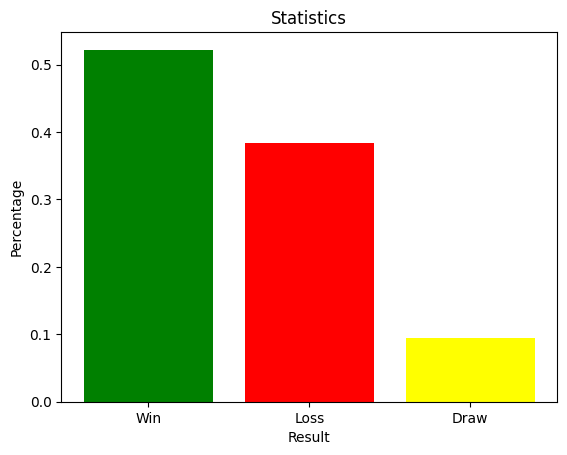

My player
win rate: 0.302
draw rate: 0.068
losts : 0.63
200000_(0)_r0_perf_my_p.png


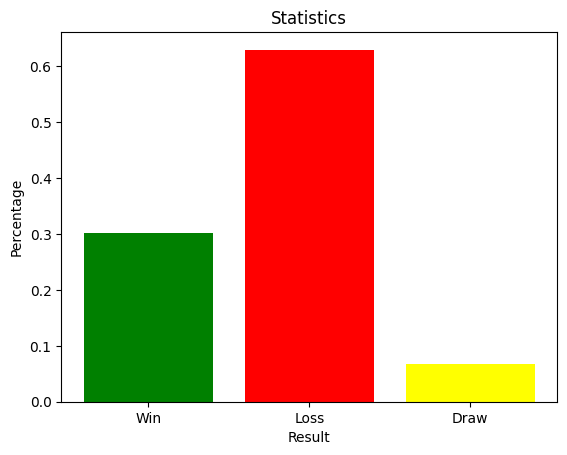

In [ ]:
a.load_q_table("q_table_200000_(0)_r0.json")
random_player_test('200000_(0)_r0_perf_')
my_player_test('200000_(0)_r0_perf_')

r1_0
Random player
win rate: 0.529
draw rate: 0.176
losts : 0.29500000000000004
200000_(0)_r1_perf_random.png


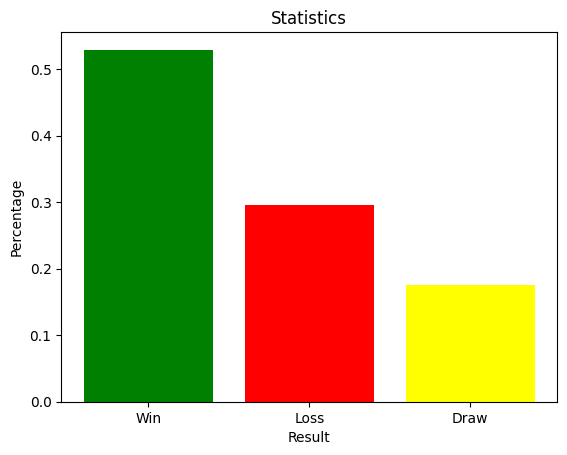

My player
win rate: 0.321
draw rate: 0.195
losts : 0.484
200000_(0)_r1_perf_my_p.png


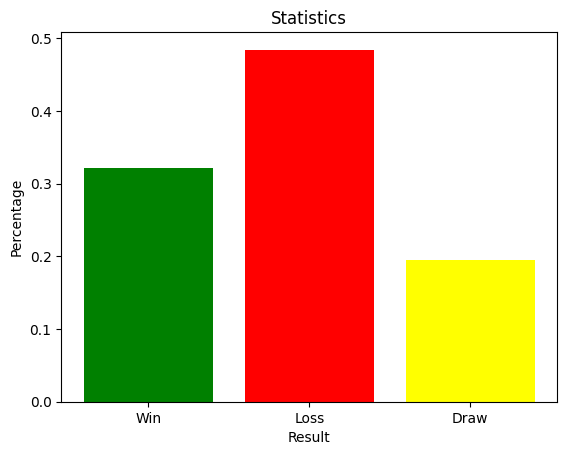

r1_1
Random player
win rate: 0.554
draw rate: 0.205
losts : 0.241
200000_(1)_r1_perf_random.png


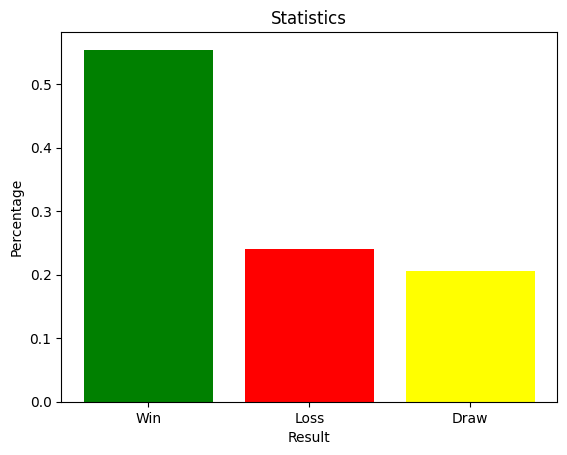

My player
win rate: 0.452
draw rate: 0.176
losts : 0.372
200000_(1)_r1_perf_my_p.png


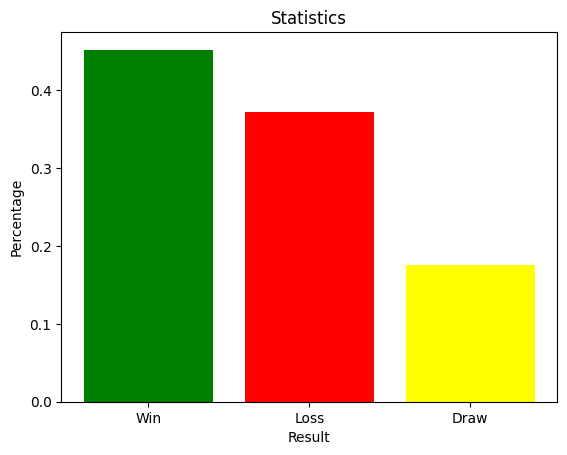

r1_2
Random player
win rate: 0.633
draw rate: 0.117
losts : 0.25
200000_(2)_r1_perf_random.png


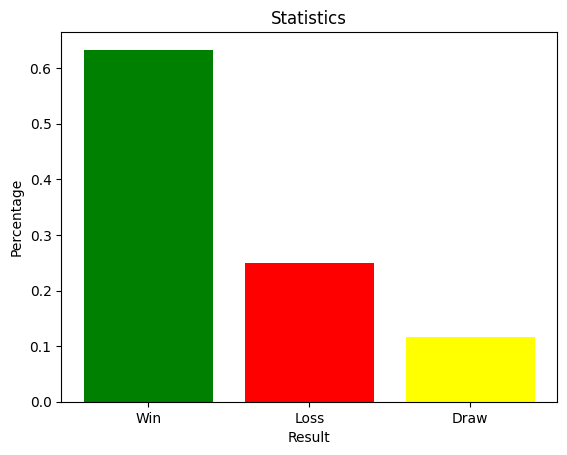

My player
win rate: 0.5
draw rate: 0.125
losts : 0.375
200000_(2)_r1_perf_my_p.png


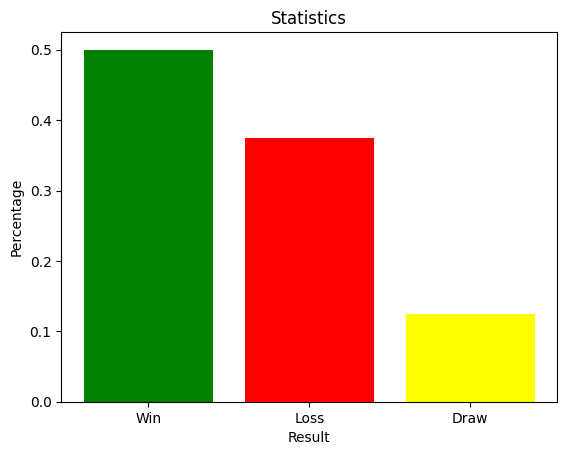

In [ ]:
for i in range(3):
  a.load_q_table(f"q_table_200000_({i})_r1.json")
  print(f"r1_{i}")
  random_player_test(f'200000_({i})_r1_perf_')
  my_player_test(f'200000_({i})_r1_perf_')

r2_0
Random player
win rate: 0.42
draw rate: 0.44
losts : 0.14
200000_(0)_r2_perf_random.png


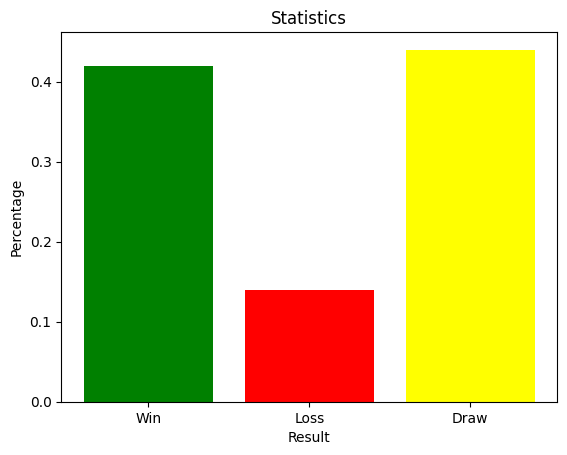

My player
win rate: 0.194
draw rate: 0.666
losts : 0.14
200000_(0)_r2_perf_my_p.png


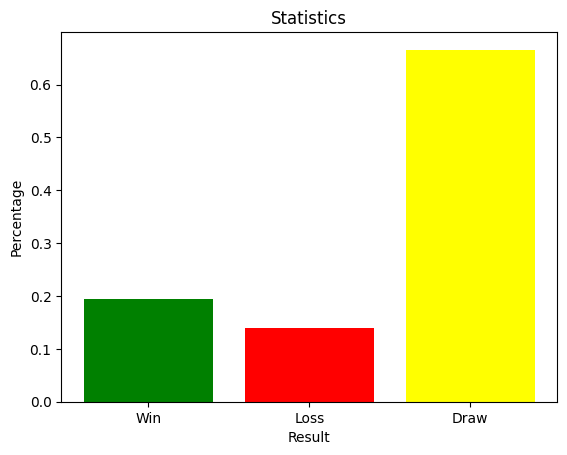

r2_1
Random player
win rate: 0.505
draw rate: 0.331
losts : 0.16400000000000003
200000_(1)_r2_perf_random.png


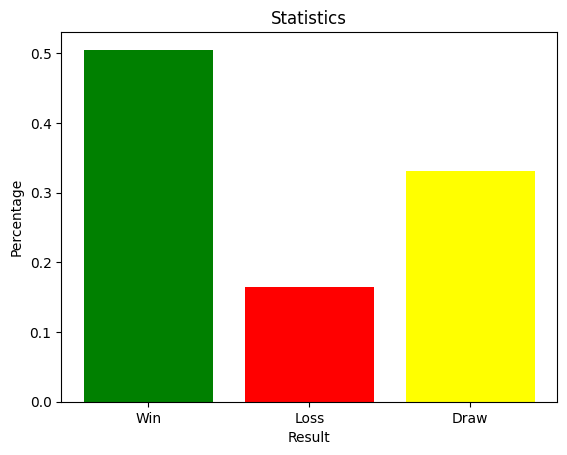

My player
win rate: 0.222
draw rate: 0.628
losts : 0.15000000000000002
200000_(1)_r2_perf_my_p.png


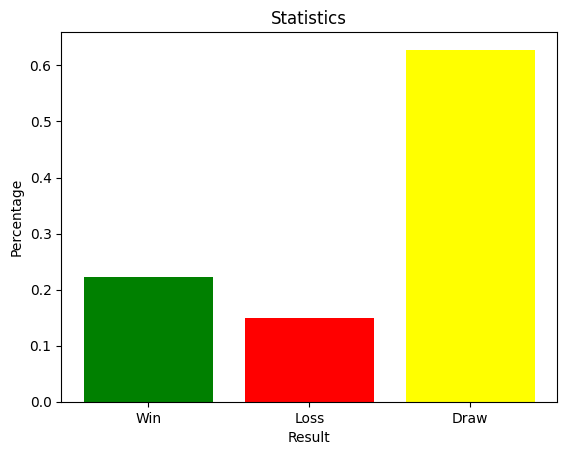

r2_2
Random player
win rate: 0.495
draw rate: 0.354
losts : 0.15100000000000002
200000_(2)_r2_perf_random.png


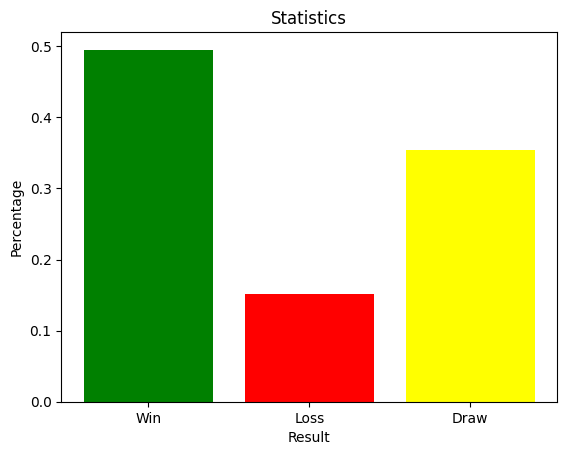

My player
win rate: 0.068
draw rate: 0.839
losts : 0.09299999999999997
200000_(2)_r2_perf_my_p.png


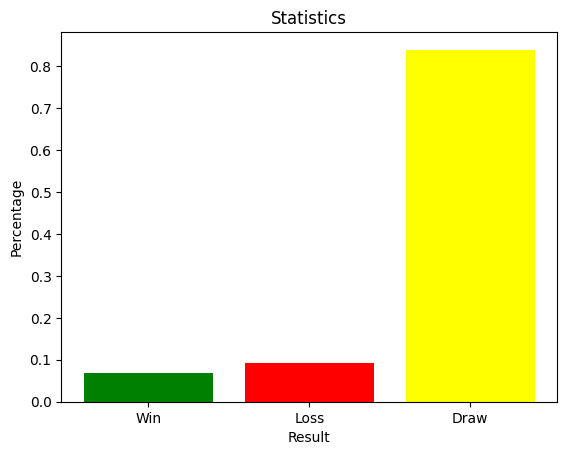

In [ ]:
for i in range(3):
    a.load_q_table(f"q_table_200000_({i})_r2.json")
    print(f"r2_{i}")
    random_player_test(f'200000_({i})_r2_perf_')
    my_player_test(f'200000_({i})_r2_perf_')

Random player
win rate: 0.473
draw rate: 0.189
losts : 0.33799999999999997
200000_(0)_r0_perf_symm_random.png


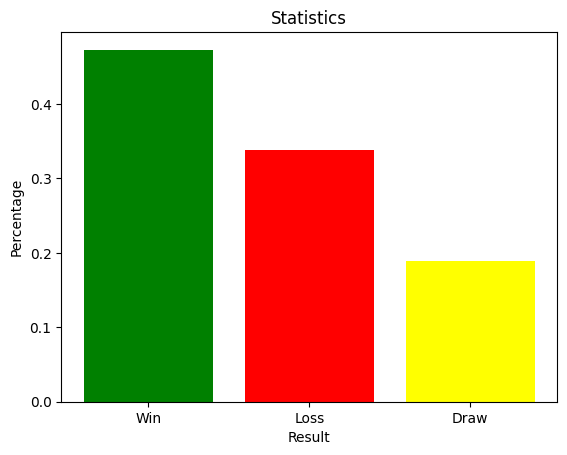

My player
win rate: 0.468
draw rate: 0.12
losts : 0.41200000000000003
200000_(0)_r0_perf_symm_my_p.png


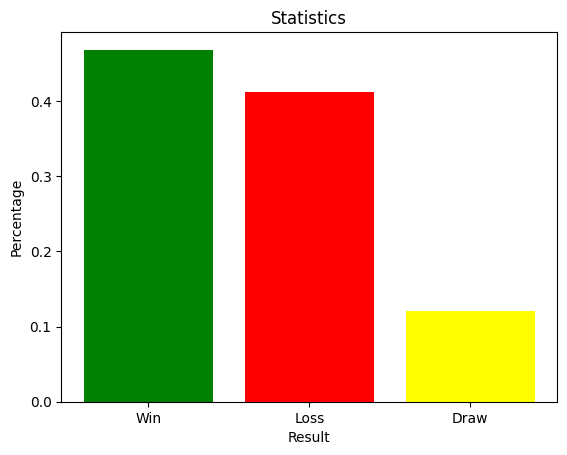

In [20]:
a = agent()
a.load_q_table("q_table_200000_(0)_r0_symm.json")
random_player_test('200000_(0)_r0_perf_symm_')
my_player_test('200000_(0)_r0_perf_symm_')

Random player
win rate: 0.734
draw rate: 0.027
losts : 0.239
200000_(1)_r0_perf_symm_random.png


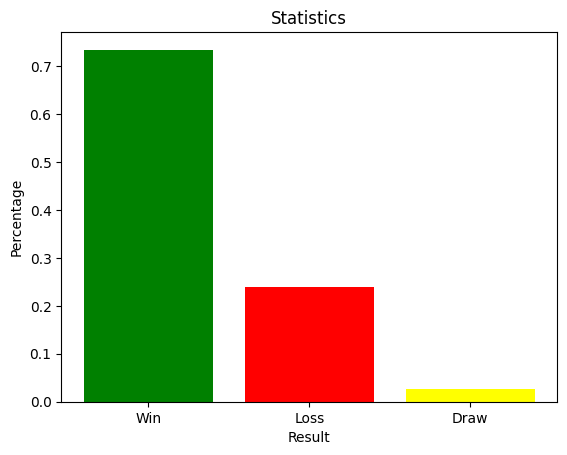

My player
win rate: 0.03
draw rate: 0.005
losts : 0.965
200000_(1)_r0_perf_symm_my_p.png


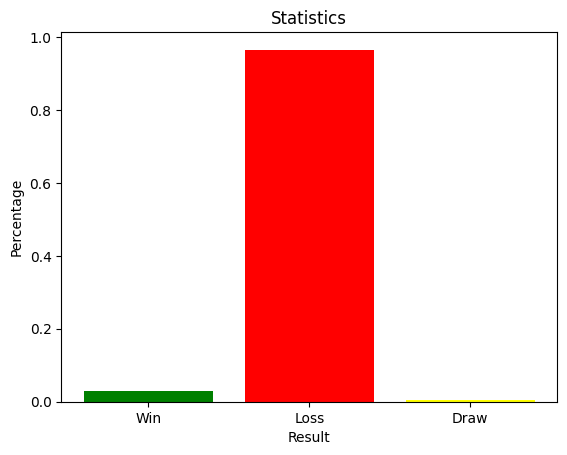

In [23]:
a = agent()
a.load_q_table("q_table_200000_(1)_r0_symm.json")
random_player_test('200000_(1)_r0_perf_symm_')
my_player_test('200000_(1)_r0_perf_symm_')

Random player
win rate: 0.393
draw rate: 0.281
losts : 0.32599999999999996
200000_(0)_r2_perf_symm_random.png


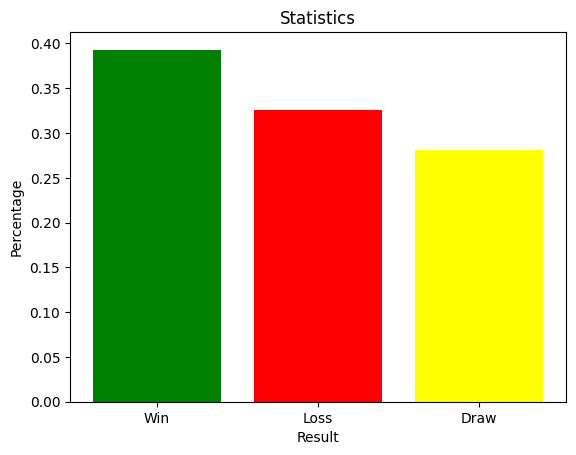

My player
win rate: 0.193
draw rate: 0.375
losts : 0.43200000000000005
200000_(0)_r2_perf_symm_my_p.png


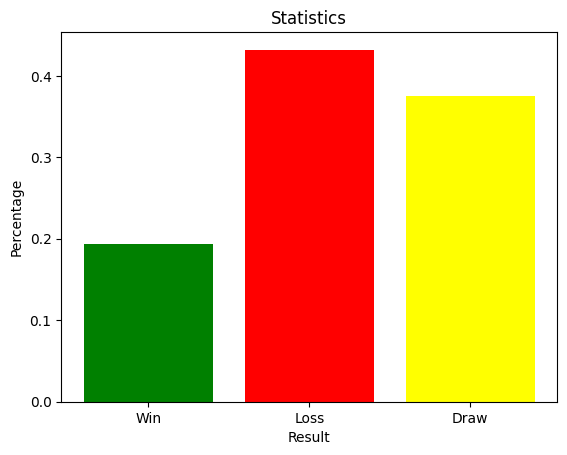

In [26]:
a = agent()
a.load_q_table("q_table_200000_(0)_r2_symm.json")
random_player_test('200000_(0)_r2_perf_symm_')
my_player_test('200000_(0)_r2_perf_symm_')